##### Grading Feedback
89%

In [1]:
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.classification import GBTClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- Students are responsible for reading the usage comments and understanding how to properly use the get_training_filename() function.  Runtime errors which result from incorrect usage of get_training_filename() shall result in a  point reduction.  
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.  Heavy weight operations that convert data to pandas or spark (like collect()) will result in a point reduction.__

### Wine Analysis
I'm a big fan of wine and would love to use visualizations, machine learning, and inference to learn more about the characteristics of a good wine and predict good wines.  Unfortunately I'm too busy (and lazy) to do the analysis myself but I do have just under 60 trained data scientests at my disposal to do the research for me.  The data set contains the following columns:<br>

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [2]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1 Data Wrangling: (10 pts)
Read the winequality-red.csv data set into a spark data frame named wine_df.  Use the get_training_filename function provided above to determine the appropriate file path based on the platform on which you are running. Check the resulting data frame for NA / NAN values and deal with these problems appropriately.  Note that the target variable has 10 classes.  Convert the 10 classes into 2 classes.  If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine.  If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.

In [3]:
# students shall create wine_df here
wine_df = spark.read.csv(get_training_filename('winequality-red.csv'), header=True, inferSchema=True)
wine_df = wine_df.withColumn("quality", \
              when(wine_df ["quality"] < 7,0).otherwise(1))

In [4]:
# grading cell: students shall print the head and shape of wine_df here
print("Shape:",(wine_df.count(),len(wine_df.columns)))
wine_df.toPandas().head(5)

Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [5]:
# grading cell: students shall prove that there are no NA / NAN values in the wine_df here
from pyspark.sql.functions import isnan, when, count, col
wine_df.select([(fn.count(fn.when(fn.isnan(c), c))).alias(c) for c in wine_df.columns]).toPandas().head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,0,0,0,0,0,0,0,0,0,0,0


##### Grading feedback cell

# Question 2 Visualizations (10 pts)
I am interested to know more about the data set.  Create one or more visualizations that summarize the data.  Write a short description that helps me understand the visualizations.  Tell me something interesting or surprising about the data.

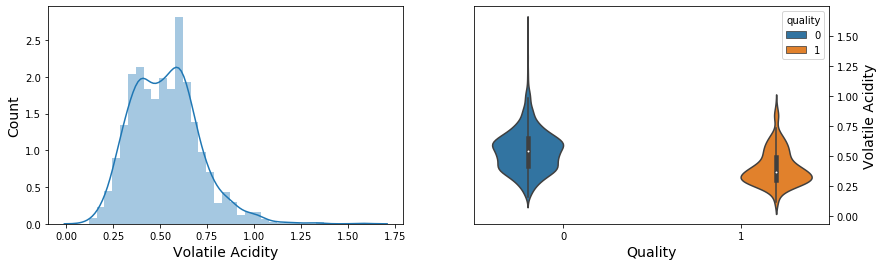

In [6]:
# your code here

import plotly.graph_objects as go
wine_df1 = wine_df.toPandas()

f, axes = plt.subplots(1,2,figsize=(14,4))

sns.distplot(wine_df1['volatile acidity'], ax = axes[0])
axes[0].set_xlabel('Volatile Acidity', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].yaxis.tick_left()

sns.violinplot(x = 'quality', y = 'volatile acidity', data = wine_df1, hue = 'quality',ax = axes[1])
axes[1].set_xlabel('Quality', fontsize=14)
axes[1].set_ylabel('Volatile Acidity', fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

Your short description here:<br> Here we see that high quality wines have less volatile acidity

[Text(0, 0.5, 'pH'),
 Text(0.5, 0, 'Wine Quality'),
 Text(0.5, 1.0, 'pH in different types of Wine quality')]

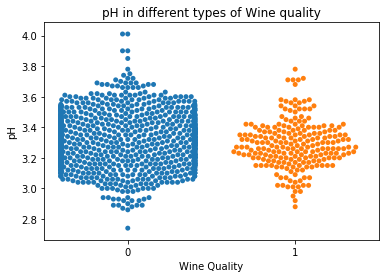

In [7]:
bx = sns.swarmplot(x="quality", y="pH", data = wine_df1);
bx.set(xlabel='Wine Quality', ylabel='pH', title='pH in different types of Wine quality')

The above plot shows ph content is more in bad quality of wine as compared to good quality.

##### Grading Feedback
-3 No plot title

# Random Forest

In [8]:
x_train, x_test = wine_df.randomSplit([0.7, 0.3],seed=50)
va = VectorAssembler().setInputCols(x_train.columns[:-1]).setOutputCol('features')
evaluator = BinaryClassificationEvaluator(labelCol='quality')

# Question 3: (10 pts)
Create a spark RandomForestClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [9]:
# Your code here
random_f = RandomForestClassifier(featuresCol='features',labelCol='quality')
random_f_pipe = Pipeline(stages=[va, random_f])
random_f_pipeline = random_f_pipe.fit(x_train)
evaluator.evaluate(random_f_pipeline.transform(x_test))

0.9218647911141847

##### Grading Feedback

# Question 4: (10 pts)
Use spark RandomForestClassifier, ParamGridBuilder, and CrossValidator objects to perform a random forest grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default random forest model above.  You are free to choose any hyper parameters you want in your grid search.  You should be able to achieve an AUC score around / above 88%. 

In [10]:
# Your grid search code here
rfparamGrid = (ParamGridBuilder().addGrid(random_f.maxDepth, [3,6,9]).addGrid(random_f.numTrees, [100,150]).addGrid(random_f.impurity, ['gini','entropy']).build())
crossval = CrossValidator(estimator = random_f_pipe ,estimatorParamMaps = rfparamGrid, evaluator = evaluator, numFolds = 3)
random_f_cross = crossval.fit(x_train)
evaluator.evaluate(random_f_cross.transform(x_test))

0.9435796917637093

In [11]:
roc = evaluator.evaluate(random_f_cross.transform(x_test))

In [12]:
bestPipeline = random_f_cross.bestModel.stages[1]
bestParams = bestPipeline.extractParamMap()

column_names = ['maxDepth','numTrees','impurity','AUC Score']
values = [bestParams[bestPipeline.getParam('maxDepth')],bestParams[bestPipeline.getParam('numTrees')],
            bestParams[bestPipeline.getParam('impurity')],roc]

##### Grading Feedback

# Question 5 (10 pts)
Extract the cross validation AUC score and specific hyper parameters used from the grid search above.  Create a pandas dataframe where the first column is the grid parameter name and the 2nd colum is the grid parameter value.  Make the last row of the pandas data frame the resulting AUC score.  Print the pandas data frame.  Describe in words in the markdown cell below what specific parameters you used in your grid and what those parameters do in the model.  For example, if you specified impurity in your grid, describe what impurity does in the random forest.  Keep the descriptions brief and at a high level, I'm just trying to see if you understand the high level concept of what the tuning parameter does.

In [13]:
# Print the pandas data frame here
pd.DataFrame(list(zip(column_names,values)),columns=['Hyper_Parameters','Best_values'])


,Hyper_Parameters,Best_values
0,maxDepth,9
1,numTrees,150
2,impurity,entropy
3,AUC Score,0.94358


Write your grid search parameter descriptions here:<br>
maxDepth : It represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. As Depth increases there is a chance of overfitting.<br>
numTrees :  Number of trees in the forest.Increasing the number of trees will decrease the variance in predictions, improving the model’s test-time accuracy.Training time increases roughly linearly in the number of trees.<br>
impurity : The measure based on which the (locally) optimal condition is chosen is called impurity.For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. These metrics measure the quality of a split. Entropy can be roughly thought of as how much variance the data has.<br>
Auc Score : AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example

##### Grading Feedback
-3 We asked for cross validation AUC and you provided test AUC

# Question 6: 5 pts
Create a pandas dataframe containing 2 columns: `feature` and `importance`.  Load the feature column with the dataset feature names and the 2nd column with the feature importances as determined by the best model produced by the grid search above.  Sort the dataframe by `importance` in descending order. In the markdown cell, tell me the 3 features that are most important to predicting a good wine.

In [14]:
# Your code here
pd.DataFrame(list(zip(wine_df.columns[:-1], bestPipeline.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)

,feature,importance
10,alcohol,0.217946
9,sulphates,0.124529
1,volatile acidity,0.098280
6,total sulfur dioxide,0.088467
2,citric acid,0.086816
0,fixed acidity,0.079406
7,density,0.076100
4,chlorides,0.065894
5,free sulfur dioxide,0.061901
3,residual sugar,0.050432


Your feature importance comments here.<br>
Alcohol, Sulphates and Volatile Acidity are the 3 features that are most important to predicting a good wine.


# Question 7:  10 pts.
Print any of the trees in the forest from the final model.  Copy the printed text to the tree printout markdown cell below and retain the same formatting and indentation as the printout so it's easy for the graders to view the data.  Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cells below.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) The top level split indicates the most important predictor in the data set.  Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above. <br>

In [15]:
# your code here
tree = random_f_cross.bestModel.stages[-1]
print(tree.trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_7203053ff707) of depth 9 with 95 nodes
  If (feature 9 <= 0.675)
   If (feature 2 <= 0.315)
    If (feature 10 <= 9.975)
     Predict: 0.0
    Else (feature 10 > 9.975)
     If (feature 1 <= 0.5825)
      If (feature 9 <= 0.445)
       Predict: 1.0
      Else (feature 9 > 0.445)
       Predict: 0.0
     Else (feature 1 > 0.5825)
      If (feature 6 <= 28.5)
       If (feature 0 <= 7.75)
        If (feature 9 <= 0.615)
         If (feature 5 <= 7.5)
          Predict: 0.0
         Else (feature 5 > 7.5)
          If (feature 1 <= 0.6525000000000001)
           Predict: 1.0
          Else (feature 1 > 0.6525000000000001)
           Predict: 0.0
        Else (feature 9 > 0.615)
         If (feature 4 <= 0.08149999999999999)
          If (feature 0 <= 6.95)
           Predict: 0.0
          Else (feature 0 > 6.95)
           Predict: 1.0
         Else (feature 4 > 0.08149999999999999)
          Predict: 1.0
       Else (feature 0 > 7.75)
        Pre

##### Grading Feedback

Paste the tree printout in this cell:<br>
DecisionTreeClassificationModel: uid=dtc_0d1497ebba54, depth=9, numNodes=147, numClasses=2, numFeatures=11
  If (feature 1 <= 0.375)
   If (feature 4 <= 0.0765)
    If (feature 10 <= 10.45)
     If (feature 6 <= 25.5)
      If (feature 7 <= 1.00027)
       If (feature 2 <= 0.485)
        If (feature 10 <= 9.275)
         Predict: 1.0
        Else (feature 10 > 9.275)
         If (feature 0 <= 7.25)
          Predict: 1.0
         Else (feature 0 > 7.25)
          Predict: 0.0
       Else (feature 2 > 0.485)
        Predict: 1.0
      Else (feature 7 > 1.00027)
       Predict: 0.0
     Else (feature 6 > 25.5)
      Predict: 0.0
    Else (feature 10 > 10.45)
     If (feature 9 <= 0.635)
      If (feature 6 <= 13.5)
       If (feature 10 <= 10.775)
        Predict: 0.0
       Else (feature 10 > 10.775)
        Predict: 1.0
      Else (feature 6 > 13.5)
       If (feature 5 <= 21.5)
        Predict: 0.0
       Else (feature 5 > 21.5)
        If (feature 6 <= 121.5)
         Predict: 0.0
        Else (feature 6 > 121.5)
         Predict: 1.0
     Else (feature 9 > 0.635)
      If (feature 0 <= 6.15)
       Predict: 0.0
      Else (feature 0 > 6.15)
       If (feature 7 <= 0.9957550000000001)
        If (feature 0 <= 8.850000000000001)
         If (feature 6 <= 49.5)
          Predict: 1.0
         Else (feature 6 > 49.5)
          If (feature 4 <= 0.0665)
           Predict: 0.0
          Else (feature 4 > 0.0665)
           Predict: 1.0
        Else (feature 0 > 8.850000000000001)
         Predict: 1.0
       Else (feature 7 > 0.9957550000000001)
        If (feature 7 <= 0.9967550000000001)
         If (feature 9 <= 0.825)
          Predict: 0.0
         Else (feature 9 > 0.825)
          If (feature 3 <= 1.85)
           Predict: 0.0
          Else (feature 3 > 1.85)
           Predict: 1.0
        Else (feature 7 > 0.9967550000000001)
         If (feature 0 <= 7.75)
          Predict: 0.0
         Else (feature 0 > 7.75)
          Predict: 1.0
   Else (feature 4 > 0.0765)
    If (feature 9 <= 0.735)
     If (feature 5 <= 9.5)
      If (feature 2 <= 0.355)
       If (feature 8 <= 3.175)
        Predict: 1.0
       Else (feature 8 > 3.175)
        Predict: 0.0
      Else (feature 2 > 0.355)
       If (feature 5 <= 6.5)
        Predict: 0.0
       Else (feature 5 > 6.5)
        Predict: 1.0
     Else (feature 5 > 9.5)
      Predict: 0.0
    Else (feature 9 > 0.735)
     If (feature 9 <= 0.775)
      If (feature 0 <= 10.45)
       Predict: 1.0
      Else (feature 0 > 10.45)
       If (feature 6 <= 28.5)
        Predict: 1.0
       Else (feature 6 > 28.5)
        Predict: 0.0
     Else (feature 9 > 0.775)
      If (feature 5 <= 4.5)
       Predict: 0.0
      Else (feature 5 > 4.5)
       If (feature 9 <= 0.805)
        Predict: 0.0
       Else (feature 9 > 0.805)
        If (feature 8 <= 3.085)
         Predict: 0.0
        Else (feature 8 > 3.085)
         If (feature 5 <= 16.5)
          Predict: 1.0
         Else (feature 5 > 16.5)
          If (feature 4 <= 0.08149999999999999)
           Predict: 1.0
          Else (feature 4 > 0.08149999999999999)
           Predict: 0.0
  Else (feature 1 > 0.375)
   If (feature 9 <= 0.675)
    If (feature 5 <= 13.5)
     If (feature 1 <= 0.6675)
      If (feature 4 <= 0.08249999999999999)
       If (feature 1 <= 0.4175)
        If (feature 9 <= 0.495)
         Predict: 1.0
        Else (feature 9 > 0.495)
         Predict: 0.0
       Else (feature 1 > 0.4175)
        Predict: 0.0
      Else (feature 4 > 0.08249999999999999)
       If (feature 10 <= 12.05)
        If (feature 2 <= 0.175)
         If (feature 4 <= 0.0895)
          If (feature 9 <= 0.555)
           Predict: 0.0
          Else (feature 9 > 0.555)
           Predict: 1.0
         Else (feature 4 > 0.0895)
          Predict: 0.0
        Else (feature 2 > 0.175)
         If (feature 1 <= 0.515)
          If (feature 5 <= 9.5)
           Predict: 0.0
          Else (feature 5 > 9.5)
           Predict: 1.0
         Else (feature 1 > 0.515)
          Predict: 0.0
       Else (feature 10 > 12.05)
        Predict: 1.0
     Else (feature 1 > 0.6675)
      Predict: 0.0
    Else (feature 5 > 13.5)
     Predict: 0.0
   Else (feature 9 > 0.675)
    If (feature 10 <= 10.525)
     If (feature 0 <= 6.15)
      If (feature 4 <= 0.07050000000000001)
       Predict: 1.0
      Else (feature 4 > 0.07050000000000001)
       Predict: 0.0
     Else (feature 0 > 6.15)
      If (feature 6 <= 47.5)
       If (feature 1 <= 0.4175)
        If (feature 2 <= 0.325)
         If (feature 9 <= 0.775)
          Predict: 1.0
         Else (feature 9 > 0.775)
          Predict: 0.0
        Else (feature 2 > 0.325)
         If (feature 8 <= 3.035)
          Predict: 1.0
         Else (feature 8 > 3.035)
          Predict: 0.0
       Else (feature 1 > 0.4175)
        Predict: 0.0
      Else (feature 6 > 47.5)
       Predict: 0.0
    Else (feature 10 > 10.525)
     If (feature 8 <= 3.335)
      If (feature 7 <= 0.996995)
       If (feature 4 <= 0.0685)
        If (feature 1 <= 0.405)
         Predict: 1.0
        Else (feature 1 > 0.405)
         Predict: 0.0
       Else (feature 4 > 0.0685)
        Predict: 0.0
      Else (feature 7 > 0.996995)
       If (feature 10 <= 11.649999999999999)
        If (feature 5 <= 29.5)
         If (feature 7 <= 0.998595)
          If (feature 1 <= 0.405)
           Predict: 1.0
          Else (feature 1 > 0.405)
           Predict: 0.0
         Else (feature 7 > 0.998595)
          Predict: 0.0
        Else (feature 5 > 29.5)
         Predict: 1.0
       Else (feature 10 > 11.649999999999999)
        If (feature 1 <= 0.425)
         If (feature 0 <= 10.05)
          Predict: 0.0
         Else (feature 0 > 10.05)
          Predict: 1.0
        Else (feature 1 > 0.425)
         Predict: 1.0
     Else (feature 8 > 3.335)
      If (feature 0 <= 7.35)
       If (feature 7 <= 0.99375)
        If (feature 5 <= 19.5)
         Predict: 1.0
        Else (feature 5 > 19.5)
         Predict: 0.0
       Else (feature 7 > 0.99375)
        If (feature 4 <= 0.0845)
         If (feature 10 <= 10.649999999999999)
          If (feature 0 <= 6.45)
           Predict: 0.0
          Else (feature 0 > 6.45)
           Predict: 1.0
         Else (feature 10 > 10.649999999999999)
          Predict: 0.0
        Else (feature 4 > 0.0845)
         Predict: 1.0
      Else (feature 0 > 7.35)
       If (feature 2 <= 0.11499999999999999)
        Predict: 1.0
       Else (feature 2 > 0.11499999999999999)
        If (feature 2 <= 0.315)
         Predict: 0.0
        Else (feature 2 > 0.315)
         Predict: 1.0





##### Grading Feedback

What specific predictor variable is being split and what is the value that determines the left / right split:<br>
Volatile acidity having index 1 is the specific predictor that is being split at the top. The value that determines the left / right split will be information gain. Volatile acidity having informaton gain as 0.375 would be higher than any other variable at this node. Therefore feature 1 <= 0.375 will determine the split.




##### Grading Feedback
-2 We are not making a left / right decision on information gain, we are making the left / right decision based on the value of volatile acidity.

Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above:<br>
In Grid Search when we define featureSubsetStartegy, it samples the features to use as candidates for splitting at each tree node. It helps in reducing the correlation between the trees. So, the top level predictor from the cross validated model might not be selected for the top node in this tree. In this example, even if the most important variable is alcohol, still the first node is splitted for volatile acidity.
In Detail Each tree is fed a bootstraped sample of same size as the original data but with replacement making it somewhat different for all the trees in the forest. This bootstrap sampling makes the trees highly correlated so to reduce the correlation we use only number of columns equal to square root of total columns for each tree to train on rather than on whole data. Randomly pick columns by taking square root of number of columns and train each tree on these randomly picked columns is done. So this makes the top level predictors to be different for each tree. This random selection of limited columns for training each tree makes the top level predictors to be different and at last we do the majority vote from the leaf nodes of all these trees to get final output to prevent overfitting and increase accuracy.

##### Grading Feedback
Excellent description

# Question 8:  10 pts.
Create a spark GBTClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [16]:
# Your Code Here
gradient = GBTClassifier(featuresCol = 'features', labelCol = 'quality')
gradient_pipe = Pipeline(stages=[va, gradient])
gradient_pipeline = gradient_pipe.fit(x_train)
evaluator.evaluate(gradient_pipeline.transform(x_test))

0.903166916484109

##### Grading Feedback

# Question 9:  10 pts.
Use spark GBTClassifier, ParamGridBuilder, and CrossValidator objects to perform a GBT grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default GBT model and the random forest model above.  You are free to experiment with any search parameters you wish.  It is also okay to experiment with maxIter and stepSize outside of the grid if you wish as long as you comment what you are doing.

In [17]:
# Your Code Here
paramGrid = ParamGridBuilder()\
            .addGrid(gradient.maxDepth, [2,5,9])\
            .addGrid(gradient.featureSubsetStrategy, ['all'])\
            .addGrid(gradient.minInstancesPerNode, [3,5])\
            .addGrid(gradient.stepSize, [0.01,0.1,1]).build()
crossval = CrossValidator(estimator=gradient_pipe, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
grad_cross = crossval.fit(x_train)
evaluator.evaluate(grad_cross.transform(x_test))

0.9092394019754794

In [18]:
roc1 = evaluator.evaluate(grad_cross.transform(x_test))

##### Grading Feedback
You again did not provide the cross validated AUC.  Why did you fix the feature subset strategy to all?

# Question 10 10 pts
Create a grid search summary pandas data frame for the GBT grid search exactly like you did in question 5 above.

In [19]:
# Your Code Here
bestPipeline = grad_cross.bestModel.stages[1]
bestParams = bestPipeline.extractParamMap()
column_names =  ['maxDepth','minInstancesPerNode','featureSubsetStrategy','stepSize','AUC Score']
values = [bestParams[bestPipeline.getParam('maxDepth')],bestParams[bestPipeline.getParam('minInstancesPerNode')],
            bestParams[bestPipeline.getParam('featureSubsetStrategy')],bestParams[bestPipeline.getParam('stepSize')],roc1]

df_gb = pd.DataFrame(list(zip(column_names,values)),columns=['Hyper_Parameters','Best_values'])
df_gb

,Hyper_Parameters,Best_values
0,maxDepth,5
1,minInstancesPerNode,5
2,featureSubsetStrategy,all
3,stepSize,0.1
4,AUC Score,0.909239


##### Grading Feedback

Add search parameter comments here<br>
maxDepth : The maximum depth of a tree. Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. <br>
minInstancesPerNode : It is the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. If all of the samples at each node, the model cannot learn enough about the data. This is an underfitting.<br>
featureSubsetStrategy : Number of features to use as candidates for splitting at each tree node. The number is specified as a fraction or function of the total number of features.<br>
stepSize : A technique to slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees when added to the model. Higher values of learning rate for the model tend to overfit(high variance). The learning rate with lower values will not allow the tree to fit the data closely.	



##### Grading Feedback Cell
-3: I disagree with the statement "Higher values of learning rate for the model tend to overfit(high variance). The learning rate with lower values will not allow the tree to fit the data closely."  For example you can overcome lower values by adding more trees.  My opionion is that the forest tends to learn better with lower values of step size.

# Question 11 (5 pts):
Create and print a pandas dataframe with the columns `feature` and `importance` just like question 6 above.  Also, compare the feature importances to random forest from question 6 above - how different or similar are the feature importances between GBT and random forest.

In [20]:
# Your code here
pd.DataFrame(list(zip(wine_df.columns[:-1], bestPipeline.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance',ascending=False)

,feature,importance
6,total sulfur dioxide,0.144004
10,alcohol,0.125048
9,sulphates,0.116648
2,citric acid,0.113496
8,pH,0.093163
1,volatile acidity,0.078642
7,density,0.074660
4,chlorides,0.069011
3,residual sugar,0.062776
5,free sulfur dioxide,0.061828


Feature importance comments here:<br>
Alcohol, Volatile Acidity and Sulphates are the 3 features that are most important to predicting a good wine

Add feature importance comparison comments here:<br>
Both the algorithms provide us similar features for predicting a good wine but for random forest the second most important feature is Sulphates whereas for gradient boosting Volatile Acidity is the second most important feature.

##### Grading Feedback